<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/TrainOnFakeNews-TestOnCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this trains on the Fake News Classification Dataset, and then tests it on the Covid19 dataset

In [1]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub

In [2]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text.strip()

path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
df = pd.read_csv("/root/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77/WELFake_Dataset.csv")

df.dropna(subset=['text', 'label'], inplace=True)
df['processed_text'] = df['text'].apply(preprocess_text)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42
)

100%|██████████| 92.1M/92.1M [00:01<00:00, 77.9MB/s]

Extracting files...


In [3]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

In [4]:
# Define the neural network
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model setup
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2
model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 268.7272
Epoch 2/10, Loss: 147.7207
Epoch 3/10, Loss: 117.4850
Epoch 4/10, Loss: 89.2538
Epoch 5/10, Loss: 59.1695
Epoch 6/10, Loss: 34.8165
Epoch 7/10, Loss: 20.4662
Epoch 8/10, Loss: 11.4458
Epoch 9/10, Loss: 8.1431
Epoch 10/10, Loss: 7.8970


In [18]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate CSV
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Load the dataset
covid_df = pd.read_csv(file_name)

# missing values
missing_values = covid_df.isnull().sum()
covid_df.dropna(subset=['tweet', 'label'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Preprocess
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text.strip()

covid_df['processed_text'] = covid_df['tweet'].apply(preprocess_text)

label_mapping = {'fake': 0, 'real': 1}
covid_df['label'] = covid_df['label'].map(label_mapping)

print("COVID-19 DataFrame after preprocessing and cleaning:")
print(covid_df.head())
print("\nCOVID-19 DataFrame Summary:")
print(covid_df.info())
print(f"Number of valid rows: {len(covid_df)}")


COVID-19 DataFrame after preprocessing and cleaning:
   id                                              tweet  label  \
0   1  Chinese converting to Islam after realising th...      0   
1   2  11 out of 13 people (from the Diamond Princess...      0   
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...      0   
3   4  Mike Pence in RNC speech praises Donald Trump’...      0   
4   5  6/10 Sky's @EdConwaySky explains the latest #C...      1   

                                      processed_text  
0  chinese converting to islam after realising th...  
1  11 out of 13 people from the diamond princess ...  
2  covid19 is caused by a bacterium not virus and...  
3  mike pence in rnc speech praises donald trumps...  
4  610 skys edconwaysky explains the latest covid...  

COVID-19 DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------


COVID-19 Dataset Results
Accuracy: 0.50
              precision    recall  f1-score   support

        Fake       0.39      0.10      0.16      1020
        Real       0.51      0.85      0.64      1120

    accuracy                           0.50      2140
   macro avg       0.45      0.48      0.40      2140
weighted avg       0.45      0.50      0.41      2140



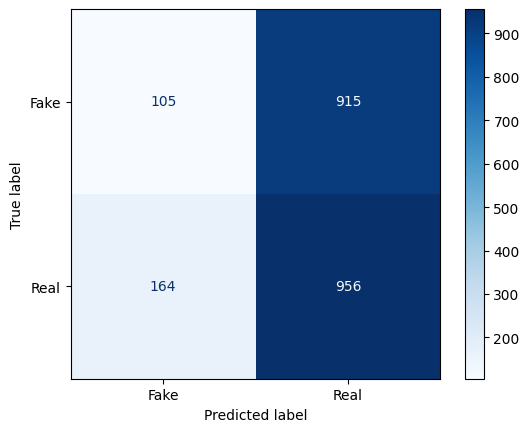

In [17]:
if covid_df.empty:
    print("No valid rows in the COVID-19 dataset.")
else:
    # Process data if there are valid rows
    X_covid = vectorizer.transform(covid_df['processed_text']).toarray()
    covid_labels = torch.tensor(covid_df['label'].values, dtype=torch.long)

    covid_dataset = TensorDataset(torch.tensor(X_covid, dtype=torch.float32), covid_labels)
    covid_loader = DataLoader(covid_dataset, batch_size=32, shuffle=False)

    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in covid_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    print("\nCOVID-19 Dataset Results")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))
    conf_matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Fake", "Real"]).plot(cmap='Blues')
    plt.show()